In [1]:
import cv2
import numpy as np
from numpy.linalg import norm

def cos_sim_feature(vector1, vector2):
    #正規化
    vector1 = vector1 / vector1.sum()
    vector2 = vector2 / vector2.sum()
    
    # ベクトルのノルムを計算
    norm_vector1 = norm(vector1)
    norm_vector2 = norm(vector2)
    
    #flatten
    vector1_flatten = vector1.ravel()
    vector2_flatten = vector2.ravel()

    # コサイン類似度を計算
    cosine_similarity = np.dot(vector1_flatten, vector2_flatten) / (norm_vector1 * norm_vector2)
    
    return cosine_similarity

TorchデータをNPY

In [2]:
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import torch
import itertools


#Define
DATASET_PATH = "DINO_OUTPUT/CROSS_3_18_epoch0010"
data_type = "train"
feature_test_pth = torch.load(os.path.join(DATASET_PATH, data_type+"feat.pth"))
label_test_pth = torch.load(os.path.join(DATASET_PATH, data_type+"labels.pth"))

label_data = label_test_pth.numpy()
feature_data = feature_test_pth.numpy()
print("data num:", len(label_data))
#data labelごとに分割
for i, label in enumerate(label_data):
    if(label==0):
        length0 = i
    if(label==1):
        length3 = i - length0   
    if(label==2):
        length5 = i - length0 - length3 

day0, feature_data = np.split(feature_data, [length0])
day3, feature_data = np.split(feature_data, [length3])
day5, feature_data = np.split(feature_data, [length5])
day7 = feature_data

print("len data", len(label_data))
print("class label:", np.unique(label_data))
print(day0.shape, day3.shape, day5.shape, day7.shape)


data num: 12000
len data 12000
class label: [0 1 2 3]
(2999, 768) (3000, 768) (3000, 768) (3001, 768)


特徴量→cos sim→NPYデータ

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import sys

save_folder_path = os.path.join(DATASET_PATH, "Cos_Sim_Annalysis_flatten_"+data_type)
if(os.path.exists(save_folder_path)==False):
    os.mkdir(save_folder_path)

days = ["day0", "day3", "day5", "day7"]
days_list = [day0, day3, day5, day7]
indices = range(len(days))# 各要素のインデックスを取得

# インデックスの組み合わせを取得
index_combinations = list(itertools.product(indices, repeat=2))

#全日付の組み合わせでnpyデータ取得
for index_combi in index_combinations:
    if index_combi[0]<=index_combi[1]:#組み合わせのかぶりなく
        cos_sim_list = []
        pairs = itertools.product(days_list[index_combi[0]], days_list[index_combi[1]])
        for pair in tqdm(pairs):
            cos_sim = cos_sim_feature(pair[0], pair[1])
            cos_sim = 0.5 * (cos_sim + 1)# 0から1の範囲にスケーリング
            cos_sim_list.append(cos_sim)
            print(cos_sim)
        np.save(os.path.join(save_folder_path, days[index_combi[0]] + "_" + days[index_combi[1]]), np.array(cos_sim_list))

NPYデータ -> グラフ化

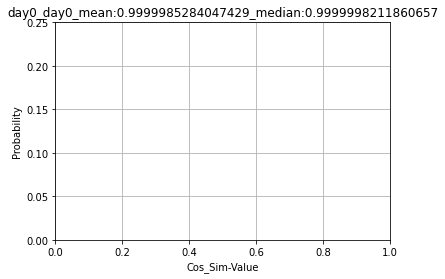

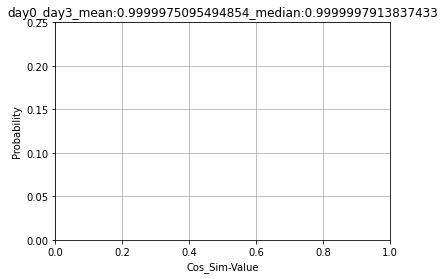

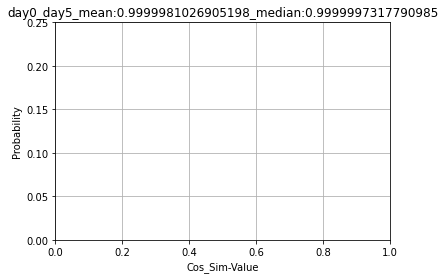

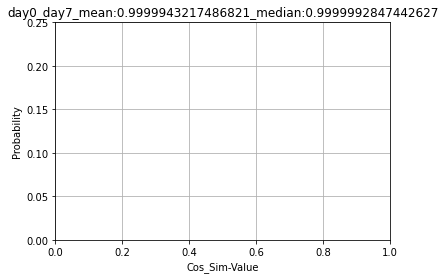

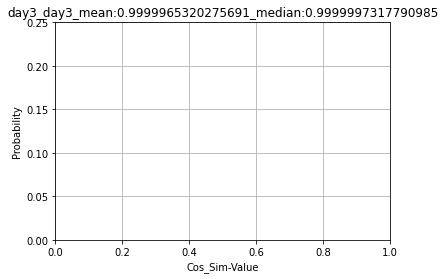

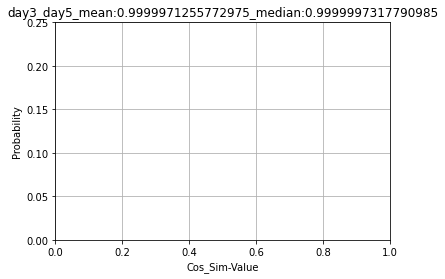

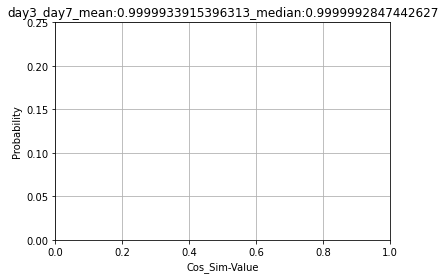

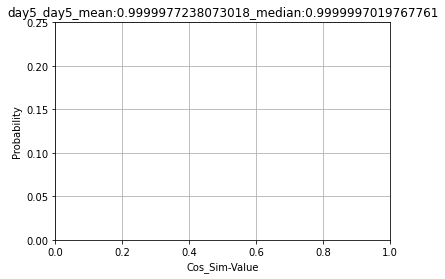

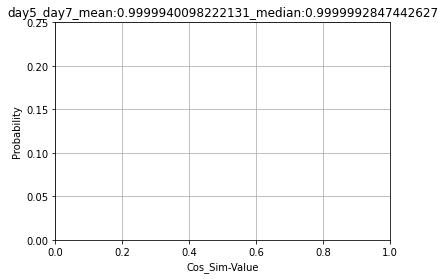

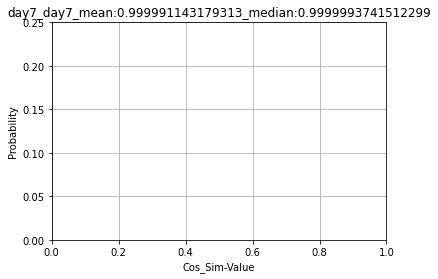

In [7]:

NPY_SAVE_FOLDER = os.path.join(DATASET_PATH,  "Cos_Sim_Annalysis_flatten_"+data_type)
SAVE_PATH = os.path.join(NPY_SAVE_FOLDER, "figure")
if(os.path.exists(SAVE_PATH)==False):
    os.mkdir(SAVE_PATH)

days = ["day0", "day3", "day5", "day7"]
days_list = [day0, day3, day5, day7]

indices = range(len(days))# 各要素のインデックスを取得

# インデックスの組み合わせを取得
index_combinations = list(itertools.product(indices, repeat=2))

#全日付の組み合わせでnpyデータ取得
for index_combi in index_combinations:
    if index_combi[0]<=index_combi[1]:#組み合わせのかぶりなく
        data = np.load(os.path.join(NPY_SAVE_FOLDER, days[index_combi[0]] + "_" + days[index_combi[1]] + ".npy"))
        data_num = len(data)
        #data = (data - np.min(data)) / (np.max(data) - np.min(data))# データを正規化

        #中央値、平均値を計算
        median = np.median(data)
        mean = np.mean(data)

        # ヒストグラムを作成
        bin_width = 0.01  # ヒストグラムのビンの幅
        bin_edges = np.arange(min(data), max(data) + bin_width, bin_width)
        plt.hist(data, bins=bin_edges, edgecolor='black', alpha=0.7, weights=np.ones(len(data)) / len(data))

        # グラフの設定
        plt.xlabel('Cos_Sim-Value')
        plt.ylabel('Probability')
        plt.title(days[index_combi[0]] + "_" + days[index_combi[1]] + "_mean:" + str(mean) + "_median:" + str(median))
        #plt.xticks(np.arange(min(data), max(data) + 1, 0.5))
        
        plt.xlim(0, 1)
        plt.ylim(0, 0.25)

        # グリッドの表示
        plt.grid(True)

        # ヒストグラムを表示
        plt.savefig(os.path.join(SAVE_PATH, days[index_combi[0]] + "_" + days[index_combi[1]]) + ".png")
        plt.show()